<a href="https://colab.research.google.com/github/Faareh-Ahmed/Segment-Green-Spaces/blob/main/Evaluation_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accuracy Metrics for SAM2 generated Masks

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.1 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import rasterio

def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

def compute_dice(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set).astype(np.float32)
    return np.mean(dice)

def compute_pixel_accuracy(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    correct_pixels = np.diag(current).sum()
    total_pixels = current.sum()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

# Load the images
with rasterio.open('/content/sample_data/segment_12NDVI_another.tif') as ndvi_file:
    ndvi_image = ndvi_file.read(1)  # Read the first band
    ndvi_image = (ndvi_image > 0.6).astype(np.uint8)

with rasterio.open('/content/sample_data/mask_12.tif') as sam_file:
    sam_mask = sam_file.read(1)  # Read the first band
    sam_mask=(sam_mask > 0).astype(np.uint8)

# Threshold NDVI to create binary ground truth (e.g., NDVI > 0.3 for vegetation)
# ndvi_binary = (ndvi_image > 0.3).astype(np.uint8)

# # Ensure the SAM mask is binary
# sam_binary = (sam_mask > 0).astype(np.uint8)

# Compute metrics
iou = compute_iou(sam_mask, ndvi_image)
dice = compute_dice(sam_mask, ndvi_image)
pixel_accuracy = compute_pixel_accuracy(sam_mask, ndvi_image)

# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RasterioIOError: Read failed. See previous exception for details.

NDVI image shape: (256, 256)
SAM mask shape: (256, 256)
Unique values in NDVI binary: [0 1]
Unique values in SAM binary: [0 1]
IoU: 0.6482
Dice Coefficient: 0.7817
Pixel Accuracy: 0.8089


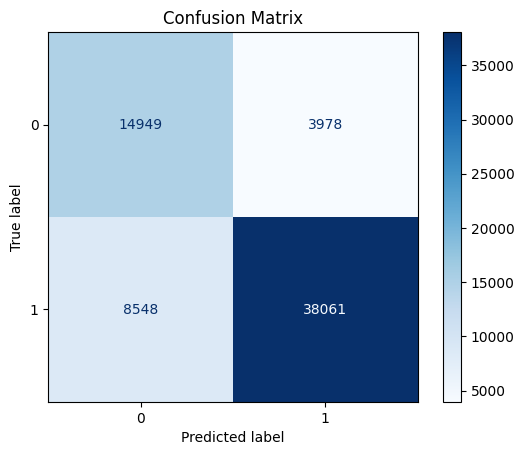

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import rasterio

# Function to compute and visualize confusion matrix
def plot_confusion_matrix(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Compute difference between NDVI and SAM masks
def compute_difference(ndvi_image, sam_mask):
    return ndvi_image - sam_mask

# Load the images
with rasterio.open('/content/sample_data/segment_12NDVI_another.tif') as ndvi_file:
    ndvi_image = ndvi_file.read(1)  # Read the first band
    ndvi_image = (ndvi_image > 0.6).astype(np.uint8)

with rasterio.open('/content/sample_data/mask_12.tif') as sam_file:
    sam_mask = sam_file.read(1)  # Read the first band
    sam_mask=(sam_mask > 0).astype(np.uint8)

print("NDVI image shape:", ndvi_image.shape)
print("SAM mask shape:", sam_mask.shape)

print("Unique values in NDVI binary:", np.unique(ndvi_image))
print("Unique values in SAM binary:", np.unique(sam_mask))
# Threshold NDVI to create binary ground truth (e.g., NDVI > 0.3 for vegetation)
# ndvi_binary = (ndvi_image > 0.3).astype(np.uint8)

# # Ensure the SAM mask is binary
# sam_binary = (sam_mask > 0).astype(np.uint8)

# Compute metrics
iou = compute_iou(sam_mask, ndvi_image)
dice = compute_dice(sam_mask, ndvi_image)
pixel_accuracy = compute_pixel_accuracy(sam_mask, ndvi_image)

# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Visualize confusion matrix
plot_confusion_matrix(sam_mask, ndvi_image)

# Compute the difference between NDVI and SAM masks
difference = compute_difference(ndvi_image, sam_mask)

# Plot the difference
# plt.figure(figsize=(8, 8))
# plt.imshow(difference, cmap='RdBu', interpolation='none')
# plt.colorbar(label='Difference (NDVI - SAM)')
# plt.title("Difference Between NDVI and SAM Masks")
# plt.show()


# For dealing with PNG output:

IoU: 0.8250
Dice Coefficient: 0.9040
Pixel Accuracy: 0.9050


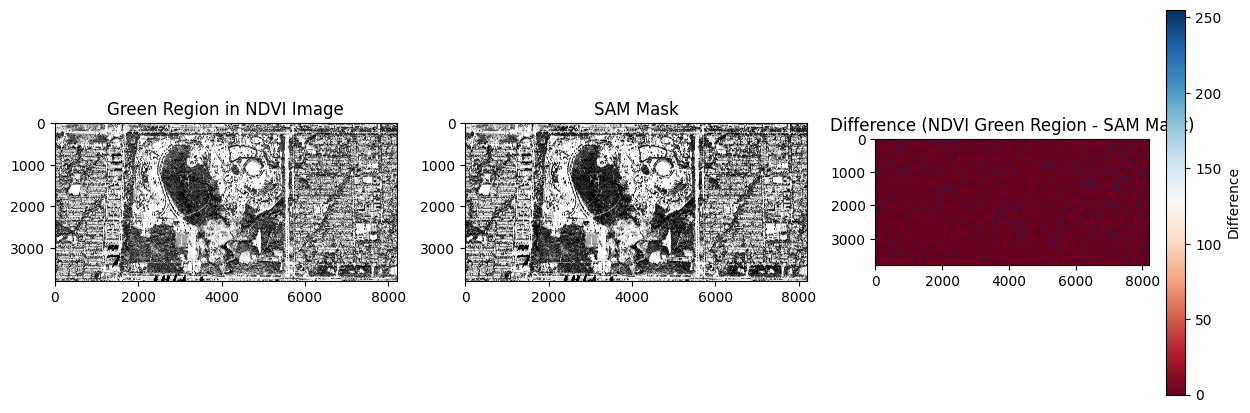

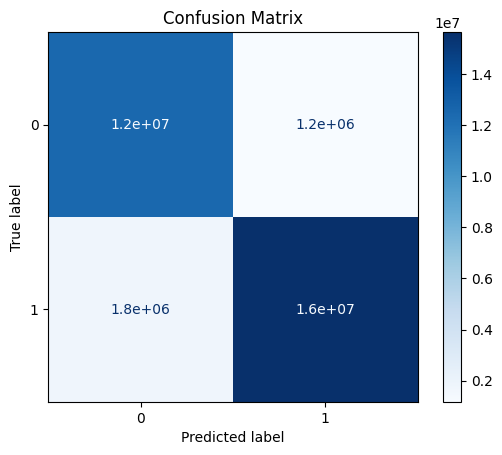

In [21]:
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Normalize image to 0-255 range
def normalize_image(image_array):
    return ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)

# Binarize the image with a threshold
def load_and_binarize_image(image_path, threshold=128):
    image = Image.open(image_path).convert("L")  # Load as grayscale
    image_array = np.array(image)
    normalized_image = normalize_image(image_array)  # Normalize first
    binary_image = (normalized_image > threshold).astype(np.uint8)
    return binary_image

# Extract green region from RGB image
def extract_green_region(image_path, lower_bound=50, upper_bound=200):
    image = Image.open(image_path).convert("RGB")  # Load as RGB
    image_array = np.array(image)
    green_mask = (image_array[..., 1] > lower_bound) & (image_array[..., 1] < upper_bound)
    return green_mask.astype(np.uint8)

# Resize or crop images to match dimensions
def resize_image(image, target_shape):
    return np.array(Image.fromarray(image).resize((target_shape[1], target_shape[0]), Image.NEAREST))

# Metrics
def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

def compute_dice(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set).astype(np.float32)
    return np.mean(dice)

def compute_pixel_accuracy(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    correct_pixels = np.diag(current).sum()
    total_pixels = current.sum()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def plot_confusion_matrix(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Paths to images
ndvi_path = '/content/sample_data/1213.jpg'
sam_mask_path = '/content/sample_data/1213_Mask_hieraLarge.png'

# Load and process images
# Extract green regions from NDVI image instead of simple binarization
ndvi_image = extract_green_region(ndvi_path, lower_bound=100, upper_bound=250)

# Binarize SAM mask
sam_mask = load_and_binarize_image(sam_mask_path, threshold=100)

# Ensure dimensions match
if ndvi_image.shape != sam_mask.shape:
    ndvi_image = resize_image(ndvi_image, sam_mask.shape)

# Compute metrics
iou = compute_iou(sam_mask, ndvi_image)
dice = compute_dice(sam_mask, ndvi_image)
pixel_accuracy = compute_pixel_accuracy(sam_mask, ndvi_image)

# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Visualize images and differences
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Green Region in NDVI Image")
plt.imshow(ndvi_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("SAM Mask")
plt.imshow(sam_mask, cmap='gray')
plt.subplot(1, 3, 3)
difference = ndvi_image - sam_mask
plt.title("Difference (NDVI Green Region - SAM Mask)")
plt.imshow(difference, cmap='RdBu', interpolation='none')
plt.colorbar(label='Difference')
plt.show()

# Confusion matrix
plot_confusion_matrix(sam_mask, ndvi_image)
